In [62]:
import lightkurve as lk
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math

In [64]:
from abc import ABC, abstractmethod

import numpy.typing as npt


class PRF(ABC):
    """A generic base class object for PRFs You're not supposed to use this"""

    def __init__(self, filename: str):
        self.filename = filename
        self._prepare()
        return

    def __repr__(self):
        return "I'm a PRF"

    def __call__(self):
        raise NotImplementedError

    def evaluate(self, kwargs):
        if rotation_angle == 0:
            self._fast_evaluate(**kwargs)
        else:
            self._evaluate(**kwargs)
        raise NotImplementedError

    def gradient(self):
        if rotation is None:
            self._fast_gradient(**kwargs)
        else:
            self._gradient(**kwargs)
        raise NotImplementedError

    def _gradient(self, center_col: float, center_row: float, 
                  flux: float = 1.0, scale_col: float = 1.0, 
                  scale_row: float = 1.0, rotation_angle: float = 0.0) 
                  -> npt.NDArray):
        """
        This function returns the gradient of the KeplerPRF model with
        respect to center_col, center_row, flux, scale_col, scale_row,
        and rotation_angle.

        Parameters
        ----------
        center_col, center_row : float
            Column and row coordinates of the center
        flux : float
            Total integrated flux of the PRF
        scale_col, scale_row : float
            Pixel scale stretch parameter, i.e. the numbers by which the PRF
            model needs to be multiplied in the column and row directions to
            account for focus changes
        rotation_angle : float
            Rotation angle in radians

        Returns
        -------
        grad_prf : list
            Returns a list of arrays where the elements are the partial derivatives
            of the PRF model with respect to center_col, center_row, flux, scale_col,
            scale_row, and rotation_angle, respectively.
        """
        cosa = math.cos(rotation_angle)
        sina = math.sin(rotation_angle)

        delta_col = self.col_coord - center_col
        delta_row = self.row_coord - center_row
        delta_col, delta_row = np.meshgrid(delta_col, delta_row)

        rot_row = delta_row * cosa - delta_col * sina
        rot_col = delta_row * sina + delta_col * cosa

        # for a proof of the maths that follow, see the pdf attached
        # on pull request #198 in lightkurve GitHub repo.
        deriv_flux = self.interpolate(
            rot_row.flatten() * scale_row, rot_col.flatten() * scale_col, grid=False
        ).reshape(self.shape)

        interp_dy = self.interpolate(
            rot_row.flatten() * scale_row,
            rot_col.flatten() * scale_col,
            grid=False,
            dy=1,
        ).reshape(self.shape)

        interp_dx = self.interpolate(
            rot_row.flatten() * scale_row,
            rot_col.flatten() * scale_col,
            grid=False,
            dx=1,
        ).reshape(self.shape)

        scale_row_times_interp_dx = scale_row * interp_dx
        scale_col_times_interp_dy = scale_col * interp_dy

        deriv_center_col = -flux * (
            cosa * scale_col_times_interp_dy - sina * scale_row_times_interp_dx
        )
        deriv_center_row = -flux * (
            sina * scale_col_times_interp_dy + cosa * scale_row_times_interp_dx
        )
        deriv_scale_row = flux * interp_dx * rot_row
        deriv_scale_col = flux * interp_dy * rot_col
        deriv_rotation_angle = flux * (
            interp_dy * scale_col * (delta_row * cosa - delta_col * sina)
            - interp_dx * scale_row * (delta_row * sina + delta_col * cosa)
        )

        return [
            deriv_center_col,
            deriv_center_row,
            deriv_flux,
            deriv_scale_col,
            deriv_scale_row,
            deriv_rotation_angle,
        ]

    def _fast_gradient(self):
        """
        This function returns the gradient of the PRF model with
        respect to flux, center_col, and center_row.
        This 'fast' version does not allow for rotation.

        Parameters
        ----------
        center_col, center_row : float
            Column and row coordinates of the center
        flux : float
            Total integrated flux of the PRF

        Returns
        -------
        grad_prf : list
            Returns a list of arrays where the elements are the derivative
            of the KeplerPRF model with respect to center_col, center_row,
            and flux, respectively.
        """
        delta_col = self.col_coord - center_col
        delta_row = self.row_coord - center_row

        deriv_flux = self.interpolate(delta_row, delta_col)
        deriv_center_col = -flux * self.interpolate(delta_row, delta_col, dy=1)
        deriv_center_row = -flux * self.interpolate(delta_row, delta_col, dx=1)

        return [deriv_center_col, deriv_center_row, deriv_flux]

    def _evaluate(self):
        raise NotImplementedError

    def _fast_evaluate(
        self, center_col: float, center_row: float, flux: float = 1.0
    ) -> npt.NDArray:
        """
        Interpolates the PRF model onto detector coordinates.
        This version does not allow for rotation. 

        Parameters
        ----------
        flux : float
            Total integrated flux of the PRF
        center_col, center_row : float
            Column and row coordinates of the center

        Returns
        -------
        prf_model : 2D array
            Two dimensional array representing the PRF values parametrized
            by flux and centroids.
        """
        delta_col = self.col_coord - center_col
        delta_row = self.row_coord - center_row
        self.prf_model = flux * self.interpolate(delta_row, delta_col)

        return self.prf_model
        


    @abstractmethod
    def _prepare(self):
        return

    @abstractmethod
    def _read(self):
        return


class KeplerPRF:
    """A KeplerPRF class"""

    def __repr__(self):
        return "I'm a Kepler PRF"

    def _prepare(self):
        #Note this is an exact copy of the existing Kepler PRF in lightkurve
        #Kepler had 5 samples per channel (4 corners and the middle)
        n_hdu = 5
        min_prf_weight = 1e-6
        module, output = channel_to_module_output(self.channel)
        # determine suitable PRF calibration file
        if module < 10:
            prefix = "kplr0"
        else:
            prefix = "kplr"
        prfs_url_path = "http://archive.stsci.edu/missions/kepler/fpc/prf/"
        prffile = (
            prfs_url_path
            + prefix
            + str(module)
            + "."
            + str(output)
            + "_2011265_prf.fits"
        )

        # read PRF images
        prfn = [0] * n_hdu
        crval1p = np.zeros(n_hdu, dtype="float32")
        crval2p = np.zeros(n_hdu, dtype="float32")
        cdelt1p = np.zeros(n_hdu, dtype="float32")
        cdelt2p = np.zeros(n_hdu, dtype="float32")

        for i in range(n_hdu):
            (
                prfn[i],
                crval1p[i],
                crval2p[i],
                cdelt1p[i],
                cdelt2p[i],
            ) = self._read_prf_calibration_file(prffile, i + 1)

        prfn = np.array(prfn)
        PRFcol = np.arange(0.5, np.shape(prfn[0])[1] + 0.5)
        PRFrow = np.arange(0.5, np.shape(prfn[0])[0] + 0.5)
        PRFcol = (PRFcol - np.size(PRFcol) / 2) * cdelt1p[0]
        PRFrow = (PRFrow - np.size(PRFrow) / 2) * cdelt2p[0]

        # interpolate the calibrated PRF shape to the target position
        rowdim, coldim = self.shape[0], self.shape[1]
        prf = np.zeros(np.shape(prfn[0]), dtype="float32")
        ref_column = self.column + 0.5 * coldim
        ref_row = self.row + 0.5 * rowdim

        for i in range(n_hdu):
            prf_weight = math.sqrt(
                (ref_column - crval1p[i]) ** 2 + (ref_row - crval2p[i]) ** 2
            )
            if prf_weight < min_prf_weight:
                prf_weight = min_prf_weight
            prf += prfn[i] / prf_weight

        prf /= np.nansum(prf) * cdelt1p[0] * cdelt2p[0]

        # location of the data image centered on the PRF image (in PRF pixel units)
        col_coord = np.arange(self.column + 0.5, self.column + coldim + 0.5)
        row_coord = np.arange(self.row + 0.5, self.row + rowdim + 0.5)
        # x-axis correspond to row-axis in scipy.RectBivariate
        # not to be confused with our convention, in which the
        # x-axis correspond to the column-axis
        interpolate = scipy.interpolate.RectBivariateSpline(PRFrow, PRFcol, prf)

        return col_coord, row_coord, interpolate, prf

    def _read(self, path, ext):
        prf_cal_file = pyfits.open(path)
        data = prf_cal_file[ext].data
        # looks like these data below are the same for all prf calibration files
        crval1p = prf_cal_file[ext].header["CRVAL1P"]
        crval2p = prf_cal_file[ext].header["CRVAL2P"]
        cdelt1p = prf_cal_file[ext].header["CDELT1P"]
        cdelt2p = prf_cal_file[ext].header["CDELT2P"]
        prf_cal_file.close()

        return data, crval1p, crval2p, cdelt1p, cdelt2p

    def plot(self, *params, **kwargs):
        pflux = self.evaluate(*params)
        plot_image(
            pflux,
            title="Kepler PRF Model, Channel: {}".format(self.channel),
            extent=(
                self.column,
                self.column + self.shape[1],
                self.row,
                self.row + self.shape[0],
            ),
            **kwargs
        )



class TessPRF:
    """A TESSprf class"""

    def __repr__(self):
        return "I'm a TESS PRF"

    def _prepare(self):
        min_prf_weight = 1e-6 #WHERE DOES THIS COME FROM?

        #For Kepler, there was 1 fits file for each module that only contained 5 points
        #TESS has a separate file for a grid of pixel locations.
        #We will find the closest 4 and go from there.
        cols= np.array([45,557,1069,1580,2092,45,557,1069,1580,2092,45,557,
            1069,1580,2092,45,557,1069,1580,2092,45,557,1069,1580,2092])
        rows= np.array([1,1,1,1,1,513,513,513,513,513,1025,1025,1025,1025,
            1025,1536,1536,1536,1536,1536,2048,2048,2048,2048,2048])
        #Find the distance from the input col/row to each TPF measurement location
        pythagorus = np.sqrt((rows-self.row)**2. + (cols-self.column)**2.)
        #Provide the index for the row/column combination that make up a box around the target location
        four_corners = np.argpartition(pythagorus,4)[:4] 
        
        #New PRF files were made beginning in sector 4.
        if sector < 4:
            prfs_url_path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/start_s0001/"
        else:
            prfs_url_path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/start_s0004/"
        
        
        prffiles = [f"{prfs_url_path}cam{camera}_ccd{ccd}/tess2019107181900-prf-1-1-row{rows[c]:04}-col{cols[c]:04}.fits" for c in four_corners]
        #print(prffiles)

        # read PRF images
        n_hdu = len(four_corners) #This format is a legacy of how Kepler's files were read in
        prfn = [0] * n_hdu
        crval1p = np.zeros(n_hdu, dtype="float32")
        crval2p = np.zeros(n_hdu, dtype="float32")
        cdelt1p = np.zeros(n_hdu, dtype="float32")
        cdelt2p = np.zeros(n_hdu, dtype="float32")
        #For each of the images, read in the required information
        for i in range(n_hdu):
            (
                prfn[i],
                crval1p[i],
                crval2p[i],
                cdelt1p[i],
                cdelt2p[i],
            ) = self._read_prf_calibration_file(prffiles[i])

        prfn = np.array(prfn)
        PRFcol = np.arange(0.5, np.shape(prfn[0])[1] + 0.5)
        PRFrow = np.arange(0.5, np.shape(prfn[0])[0] + 0.5)
        PRFcol = (PRFcol - np.size(PRFcol) / 2) * cdelt1p[0]
        PRFrow = (PRFrow - np.size(PRFrow) / 2) * cdelt2p[0]

        # interpolate the calibrated PRF shape to the target position
        rowdim, coldim = self.shape[0], self.shape[1]
        prf = np.zeros(np.shape(prfn[0]), dtype="float32")
        ref_column = self.column + 0.5 * coldim
        ref_row = self.row + 0.5 * rowdim

        for i in range(n_hdu):
            prf_weight = math.sqrt(
                (ref_column - crval1p[i]) ** 2 + (ref_row - crval2p[i]) ** 2
            )
            if prf_weight < min_prf_weight:
                prf_weight = min_prf_weight
            prf += prfn[i] / prf_weight

        

        # location of the data image centered on the PRF image (in PRF pixel units)
        col_coord = np.arange(self.column + 0.5, self.column + coldim + 0.5)
        row_coord = np.arange(self.row + 0.5, self.row + rowdim + 0.5)
        # x-axis correspond to row-axis in scipy.RectBivariate
        # not to be confused with our convention, in which the
        # x-axis correspond to the column-axis
        interpolate = scipy.interpolate.RectBivariateSpline(PRFrow, PRFcol, prf)
        
        fig, ax = plt.subplots(2,2)
        for i in range(n_hdu):
            #print(i)
            ax.flatten()[i].imshow(np.log(prfn[i]), origin='lower')
            
        return col_coord, row_coord, interpolate, prf

    def _read(self, path):
        #The TESS fits file is different than Kepler. We always want the first extension. The second is the errors.
        prf_cal_file = fits.open(path)
        data = prf_cal_file[0].data
        # looks like these data below are the same for all prf calibration files
        crval1p = prf_cal_file[0].header["CRVAL1P"]
        crval2p = prf_cal_file[0].header["CRVAL2P"]
        cdelt1p = prf_cal_file[0].header["CDELT1P"]
        cdelt2p = prf_cal_file[0].header["CDELT2P"]
        prf_cal_file.close()

        return data, crval1p, crval2p, cdelt1p, cdelt2p
        
    def plot(self, *params, **kwargs):
        pflux = self.evaluate(*params)
        plot_image(
            pflux,
            title="TESS PRF Model, Camera: {}, CCD: {}".format(self.camera, self.ccd),
            extent=(
                self.column,
                self.column + self.shape[1],
                self.row,
                self.row + self.shape[0],
            ),
            **kwargs
        )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 76)

In [57]:
prf_file = fits.open('/Users/ssagear/Downloads/tess2019107181900-prf-1-1-row0001-col0045.fits')

In [58]:
from lightkurve.prf import KeplerPRF

kepprf = KeplerPRF(channel=44, shape=(10, 10), column=5, row=5)

In [59]:
kepprf(flux=1000, center_col=10, center_row=10, scale_row=0.7, scale_col=0.7, rotation_angle=math.pi/2)

array([[ 3.82190069e-02,  7.00594603e-02,  1.26785322e-01,
         3.70048954e-01,  5.46417246e-01,  5.18008356e-01,
         4.28681580e-01,  2.37006748e-01,  1.32653260e-01,
         5.49634824e-02],
       [ 7.09604369e-02,  1.73029849e-01,  4.86632195e-01,
         1.18617770e+00,  2.20604516e+00,  2.54073352e+00,
         1.64401650e+00,  6.23844254e-01,  3.23765972e-01,
         1.43434787e-01],
       [ 7.36316778e-02,  2.85367457e-01,  1.25282885e+00,
         4.94532373e+00,  1.19117356e+01,  1.07780788e+01,
         6.56732144e+00,  3.18062516e+00,  7.54218471e-01,
         3.71240073e-01],
       [ 1.95298315e-01,  6.26670586e-01,  3.74899380e+00,
         1.90179847e+01,  6.85442044e+01,  5.57745019e+01,
         2.23001618e+01,  7.54463525e+00,  2.62027615e+00,
         6.78699992e-01],
       [ 2.44115949e-01,  1.16212018e+00,  7.36866713e+00,
         6.64892582e+01,  3.98829067e+02,  2.69009911e+02,
         5.03061305e+01,  1.32825990e+01,  4.10099154e+00,
         8.

In [60]:
kepprf

In [4]:
prf_image = prf_file[0].data

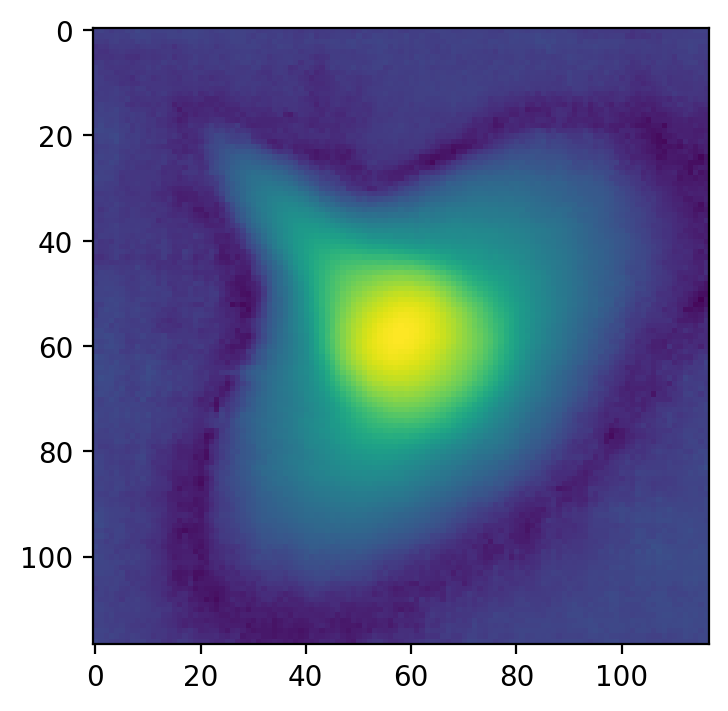

In [5]:
fig, ax = plt.subplots(dpi=200, figsize=(4,4));
ax.imshow(prf_image, norm='log')

In [12]:
pixels = prf_image.shape[0] / 9

In [13]:
pixels

13.0

In [14]:
hsplitted = np.hsplit(prf_image, pixels)

In [20]:
blocks = [np.vsplit(im, pixels) for im in hsplitted]
np.array(blocks).shape

(13, 13, 9, 9)

In [21]:
pixelated = np.sum(blocks, axis=(2,3))

In [24]:
np.array(blocks).shape, pixelated.shape

((13, 13, 9, 9), (13, 13))

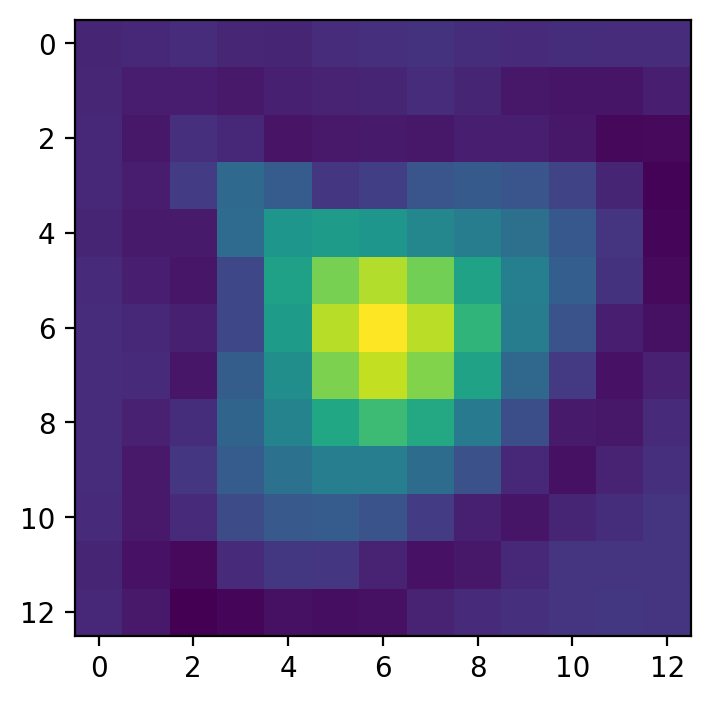

In [25]:
fig, ax = plt.subplots(dpi=200, figsize=(4,4));
ax.imshow(pixelated, norm='log')

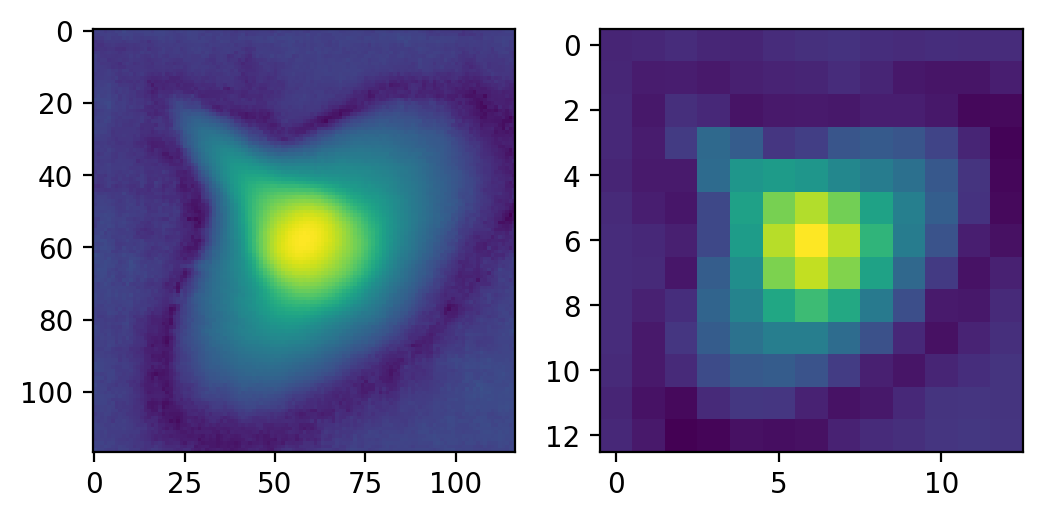

In [26]:
fig, axs = plt.subplots(ncols=2, dpi=(200), figsize=(6,3))
axs[0].imshow(prf_image, norm='log')
axs[1].imshow(pixelated, norm='log')

In [68]:
lk.KeplerTargetPixelFile()

TypeError: __init__() missing 1 required positional argument: 'path'